In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'ccdata:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F14701%2F19663%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240126%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240126T205120Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D31475c3fe9f1853d4890ef3282db803d3a59ae45667d2e03045cd6da41a678a41a89bfced3d85e49f17eeef268c234c51367b6c9c296fcc21456367b82e9a887280255bc24be2a11be28d7bc556e966ba3639e510d21b529f4bc59ac1536f52398f40b32cc047904798b0b659147a8c91136cee1773dfee7515e26f748b677b66133c7ccc2ac11da3a5889e2e84a85aebfc5e88ea325a4efeb4d51c47957fe13e620367a3da21ceaf2d59901adca1285771294c09433aa27ad4df4cfdc4dcf26ce44bc1b85e7b3bec5a6e598d5b5c22b71a6fd3f3b77aac2d178111b18856e0114af563665a1c12f843c96117134f5eee342a52edc407407d2367da26a9f90eb'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 348486 bytes downloaded
Downloaded and uncompressed: ccdata
Data source import complete.


# Hierarchical clustering

<b>Hierarchical clustering </b> (also called hierarchical cluster analysis or HCA) is a method of cluster analysis which seeks to build a hierarchy of clusters. Strategies for hierarchical clustering generally fall into two types:

- <b>Agglomerative </b>: This is a "bottom-up" approach: each observation starts in its own cluster, and pairs of clusters are merged as one moves up the hierarchy.
- <b>Divisive </b>: This is a "top-down" approach: all observations start in one cluster, and splits are performed recursively as one moves down the hierarchy.

In general, the merges and splits are determined in a greedy manner. The results of hierarchical clustering are usually presented in a dendrogram.

## Agglomerative Clustering

Initially each data point is considered as an individual cluster. At each iteration, the similar clusters merge with other clusters until 1/ K clusters are formed.

The main advantage is that we don’t need to specify the number of clusters, this comes with a price: performance $O(n^3)$. In sklearn’s implementation, we can specify the number of clusters to assist the algorithm’s performance.

### Algorithm
- Compute the proximity matrix
- Let each data point be a cluster
- Repeat: Merge two closest clusters and update the proximity matrix until 1/ K cluster remains

Ex. - We have six data points {A,B,C,D,E,F}.

- In the initial step, we consider all the six data points as individual clusters as shown in the image below.

![Screen%20Shot%202019-08-30%20at%2018.06.56.png](attachment:Screen%20Shot%202019-08-30%20at%2018.06.56.png)

- The first step is to determine which elements to merge in a cluster. Usually, we want to take the two closest elements, according to the chosen distance.We construct a distance matrix at this stage, where the number in the i-th row j-th column is the distance between the i-th and j-th elements. Then, as clustering progresses, rows and columns are merged as the clusters are merged and the distances updated.

#### Computation of proximity/distance matrix

The choice of an appropriate metric will influence the shape of the clusters, as some elements may be close to one another according to one distance and farther away according to another. For example, in a 2-dimensional space, the distance between the point (1,0) and the origin (0,0) is always 1 according to the usual norms, but the distance between the point (1,1) and the origin (0,0) can be 2 under Manhattan distance, $\sqrt2$ under Euclidean distance, or 1 under maximum distance.

Some commonly used metrics for hierarchical clustering are:

![Screen%20Shot%202019-08-30%20at%2018.03.52.png](attachment:Screen%20Shot%202019-08-30%20at%2018.03.52.png)

For text or other non-numeric data, metrics such as the Hamming distance or Levenshtein distance are often used.

- Similar clusters are merged together and formed as a single cluster. Let’s consider B,C, and D,E are similar clusters that are merged in step two. Now, we’re left with four clusters which are A, BC, DE, F. To calculate the proximity between two clusters, we need to define the distance between them. Usually the distance is one of the following:
     - The maximum distance between elements of each cluster (also called  <b> complete-linkage clustering </b>)
     - The minimum distance between elements of each cluster (also called <b> single-linkage clustering </b>)
     - The mean distance between elements of each cluster (also called <b> average linkage clustering </b>)
     - The sum of all intra-cluster variance.
- Again calculate the proximity of new clusters and merge the similar clusters to form new clusters A, BC, DEF.
- Calculate the proximity of the new clusters. The clusters DEF and BC are similar and merged together to form a new cluster. We’re now left with two clusters A, BCDEF.
- Finally, all the clusters are merged together and form a single cluster.



The Hierarchical clustering Technique can be visualized using a Dendrogram.
A Dendrogram is a tree-like diagram that records the sequences of merges or splits.

![Screen%20Shot%202019-08-30%20at%2018.07.26.png](attachment:Screen%20Shot%202019-08-30%20at%2018.07.26.png)

### Example


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import scipy.cluster.hierarchy as shc

In [3]:
raw_df = pd.read_csv('../input/ccdata/CC GENERAL.csv')
raw_df = raw_df.drop('CUST_ID', axis = 1)
raw_df.fillna(method ='ffill', inplace = True)
raw_df.head(2)

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,40.900749,0.818182,95.4,0.0,95.4,0.000000,0.166667,0.0,0.083333,0.00,0,2,1000.0,201.802084,139.509787,0.000000,12
1,3202.467416,0.909091,0.0,0.0,0.0,6442.945483,0.000000,0.0,0.000000,0.25,4,0,7000.0,4103.032597,1072.340217,0.222222,12


In [4]:
# Standardize data
scaler = StandardScaler()
scaled_df = scaler.fit_transform(raw_df)

# Normalizing the Data
normalized_df = normalize(scaled_df)

# Converting the numpy array into a pandas DataFrame
normalized_df = pd.DataFrame(normalized_df)

# Reducing the dimensions of the data
pca = PCA(n_components = 2)
X_principal = pca.fit_transform(normalized_df)
X_principal = pd.DataFrame(X_principal)
X_principal.columns = ['P1', 'P2']

X_principal.head(2)

,P1,P2
0,-0.489949,-0.679977
1,-0.519098,0.544825


<b>Dendograms </b> are used to divide a given cluster into many different clusters.

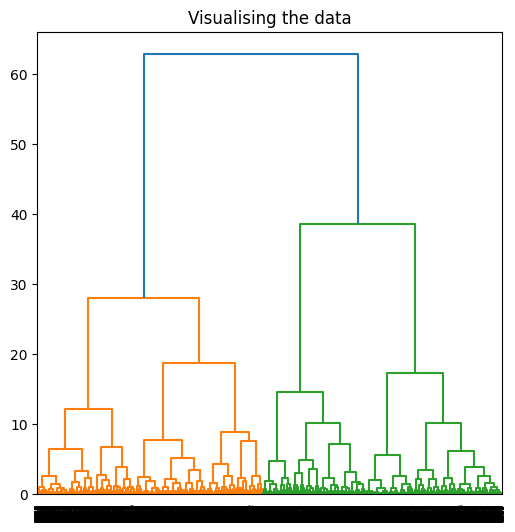

In [5]:
plt.figure(figsize =(6, 6))
plt.title('Visualising the data')
Dendrogram = shc.dendrogram((shc.linkage(X_principal, method ='ward')))

Determine the optimal number of clusters using <b> [Silhouette Score](https://www.kaggle.com/vipulgandhi/kmeans-detailed-explanation)</b>.

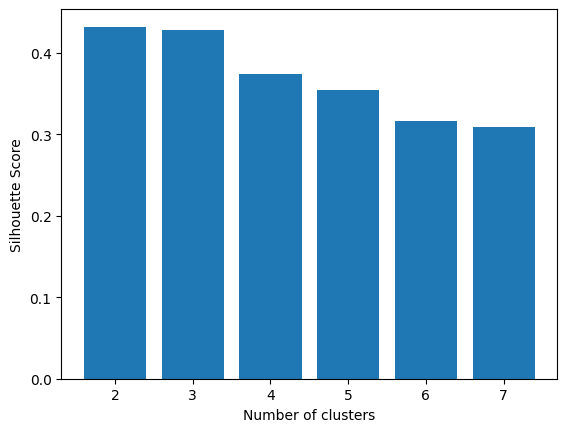

In [6]:
silhouette_scores = []

for n_cluster in range(2, 8):
    silhouette_scores.append(
        silhouette_score(X_principal, AgglomerativeClustering(n_clusters = n_cluster).fit_predict(X_principal)))

# Plotting a bar graph to compare the results
k = [2, 3, 4, 5, 6,7]
plt.bar(k, silhouette_scores)
plt.xlabel('Number of clusters', fontsize = 10)
plt.ylabel('Silhouette Score', fontsize = 10)
plt.show()

Building and Visualizing clustering model for k = 3

In [7]:
agg = AgglomerativeClustering(n_clusters=3)
agg.fit(X_principal)

AgglomerativeClustering(n_clusters=3)

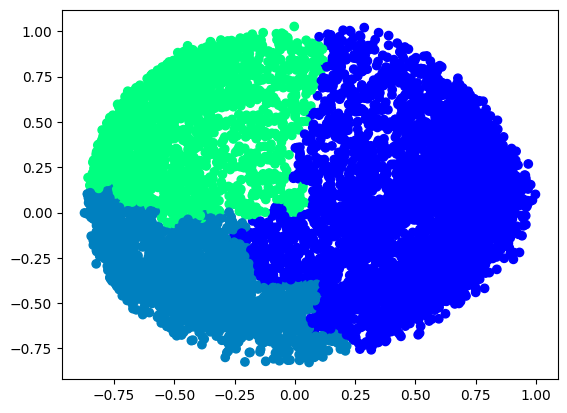

In [8]:
# Visualizing the clustering
plt.scatter(X_principal['P1'], X_principal['P2'],
           c = AgglomerativeClustering(n_clusters = 3).fit_predict(X_principal), cmap =plt.cm.winter)
plt.show()